In [20]:
!pip install transformers datasets rouge-score sumy bs4 nltk
!rm -rf /root/.cache/huggingface

import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
import pandas as pd

df = pd.read_csv("xsum.csv")
subset = df.head(50)
df.head()


,id,input,target,answer_choices,eval_type
0,0,The ex-Reading defender denied fraudulent trad...,Former Premier League footballer Sam Sodje has...,NaN,generation
1,1,Voges was forced to retire hurt on 86 after su...,Middlesex batsman Adam Voges will be out until...,NaN,generation
2,2,Seven photographs taken in the Norfolk country...,The Duchess of Cambridge will feature on the c...,NaN,generation
3,3,"Chris Poole - known as ""moot"" online - created...",Google has hired the creator of one of the web...,NaN,generation
4,4,Four police officers were injured in the incid...,Two teenagers have been charged in connection ...,NaN,generation


In [23]:
from transformers import BartTokenizer, BartForConditionalGeneration

bart_model_name = "facebook/bart-large-xsum"
bart_tokenizer = BartTokenizer.from_pretrained(bart_model_name)
bart_model = BartForConditionalGeneration.from_pretrained(bart_model_name)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

In [24]:
from tqdm import tqdm

bart_summaries = []

for text in tqdm(subset["input"].tolist(), desc="BART Summaries"):
    inputs = bart_tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = bart_model.generate(inputs, max_length=60, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    bart_summaries.append(summary)

subset["bart_summary"] = bart_summaries



BART Summaries: 100%|██████████| 50/50 [06:45<00:00,  8.11s/it]
<ipython-input-24-f57b5ec06dde>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["bart_summary"] = bart_summaries


In [26]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base")


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [27]:
t5_summaries = []

for text in tqdm(subset["input"].tolist(), desc="T5 Summaries"):
    input_text = "summarize: " + text
    inputs = t5_tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=60, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    t5_summaries.append(summary)

subset["t5_summary"] = t5_summaries


T5 Summaries: 100%|██████████| 50/50 [08:20<00:00, 10.00s/it]
<ipython-input-27-91e0e44ab90f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["t5_summary"] = t5_summaries


In [29]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
import nltk # Ensure nltk is imported here as well

# Download the missing resource
nltk.download('punkt_tab')

textrank_summaries = []

for text in tqdm(subset["input"].tolist(), desc="TextRank Summaries"):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, 3)  # 3 جمل
    joined = " ".join(str(sentence) for sentence in summary)
    textrank_summaries.append(joined)

subset["textrank_summary"] = textrank_summaries

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
TextRank Summaries: 100%|██████████| 50/50 [00:01<00:00, 32.96it/s]
<ipython-input-29-ed9e6fe49074>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["textrank_summary"] = textrank_summaries


In [30]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def compute_rouge(refs, gens):
    r1, r2, rL = [], [], []
    for ref, gen in zip(refs, gens):
        scores = scorer.score(ref, gen)
        r1.append(scores["rouge1"].fmeasure)
        r2.append(scores["rouge2"].fmeasure)
        rL.append(scores["rougeL"].fmeasure)
    return r1, r2, rL

bart_r1, bart_r2, bart_rL = compute_rouge(subset["target"], subset["bart_summary"])
t5_r1, t5_r2, t5_rL = compute_rouge(subset["target"], subset["t5_summary"])
txt_r1, txt_r2, txt_rL = compute_rouge(subset["target"], subset["textrank_summary"])


In [31]:
def print_rouge(name, r1, r2, rL):
    print(f"\n{name} ROUGE Scores")
    print(f"ROUGE-1: {sum(r1)/len(r1):.4f}")
    print(f"ROUGE-2: {sum(r2)/len(r2):.4f}")
    print(f"ROUGE-L: {sum(rL)/len(rL):.4f}")

print_rouge("BART", bart_r1, bart_r2, bart_rL)
print_rouge("T5", t5_r1, t5_r2, t5_rL)
print_rouge("TextRank", txt_r1, txt_r2, txt_rL)



BART ROUGE Scores
ROUGE-1: 0.4821
ROUGE-2: 0.2541
ROUGE-L: 0.4075

T5 ROUGE Scores
ROUGE-1: 0.1975
ROUGE-2: 0.0366
ROUGE-L: 0.1425

TextRank ROUGE Scores
ROUGE-1: 0.1633
ROUGE-2: 0.0276
ROUGE-L: 0.1107


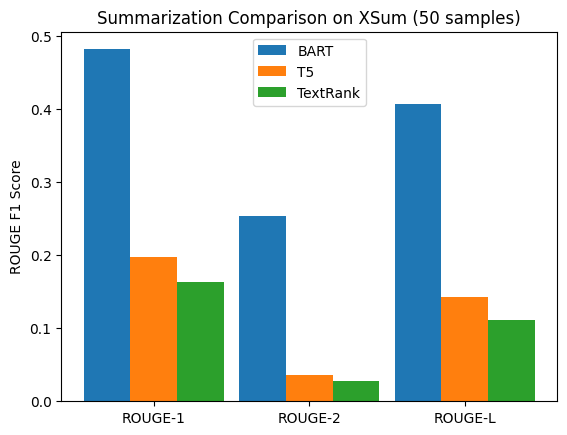

In [32]:
import matplotlib.pyplot as plt

labels = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
x = range(len(labels))

plt.bar([i - 0.3 for i in x], [sum(bart_r1)/len(bart_r1), sum(bart_r2)/len(bart_r2), sum(bart_rL)/len(bart_rL)], width=0.3, label="BART")
plt.bar(x, [sum(t5_r1)/len(t5_r1), sum(t5_r2)/len(t5_r2), sum(t5_rL)/len(t5_rL)], width=0.3, label="T5")
plt.bar([i + 0.3 for i in x], [sum(txt_r1)/len(txt_r1), sum(txt_r2)/len(txt_r2), sum(txt_rL)/len(txt_rL)], width=0.3, label="TextRank")

plt.xticks(x, labels)
plt.ylabel("ROUGE F1 Score")
plt.title("Summarization Comparison on XSum (50 samples)")
plt.legend()
plt.show()


In [33]:
subset.to_csv("xsum_bart_t5_textrank_comparison.csv", index=False)
print("Saved to xsum_bart_t5_textrank_comparison.csv")


Saved to xsum_bart_t5_textrank_comparison.csv
